In [2]:
#! pip install pylibjpeg -q
#! pip install python-gdcm -q
#! pip install pylibjpeg-libjpeg -q


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.6.2 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


In [5]:
!pip install fastai kornia pydicom -q

In [1]:
import numpy as np 
import pandas as pd 
import os

## new library - https://docs.fast.ai/
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastcore.all import *

## image handling and plotting
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pathlib import Path

In [2]:
#Get working directory and define training data
DATA_DIR = Path("project_data/")
train_cases = list((DATA_DIR/"train_images").glob('*'))

In [3]:
from tqdm.notebook import tqdm
print(len(train_cases))

1882


In [4]:
## FastAI get metadata for first image in training images
first_images = []
for case in tqdm(train_cases):
    fns = list(case.glob('*'))
    first_images.append(fns[0]) #there are 2019 images that make up first training case

  0%|          | 0/1882 [00:00<?, ?it/s]

In [5]:
#FastAI converts dicom data to a dataframe
metadata = pd.DataFrame.from_dicoms(first_images)
metadata.head()

,SOPInstanceUID,ContentDate,ContentTime,PatientName,PatientID,SliceThickness,StudyInstanceUID,SeriesInstanceUID,InstanceNumber,MultiImagePositionPatient,...,fname,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
0,1.2.826.0.1.3680043.10001.1.1,20220727,175846.217587,"(1, 0, 0, 0, 1)",10001,0.625,1.2.826.0.1.3680043.10001,1.2.826.0.1.3680043.10001.1,1,1,...,project_data/train_images/1.2.826.0.1.3680043.10001/1.dcm,-2000,3326,404.178375,1344.344627,0.230789,NaN,NaN,NaN,NaN
1,1.2.826.0.1.3680043.10005.1.1,20220727,183602.720975,"(1, 0, 0, 0, 5)",10005,0.625,1.2.826.0.1.3680043.10005,1.2.826.0.1.3680043.10005.1,1,1,...,project_data/train_images/1.2.826.0.1.3680043.10005/1.dcm,-1024,2924,412.014046,914.395781,0.164436,NaN,NaN,NaN,NaN
2,1.2.826.0.1.3680043.10014.1.1,20220727,180849.500047,"(1, 0, 0, 1, 4)",10014,1.000,1.2.826.0.1.3680043.10014,1.2.826.0.1.3680043.10014.1,1,1,...,project_data/train_images/1.2.826.0.1.3680043.10014/1.dcm,-3678,3625,-309.851555,993.090162,0.268394,NaN,NaN,NaN,NaN
3,1.2.826.0.1.3680043.10016.1.1,20220727,181705.405318,"(1, 0, 0, 1, 6)",10016,0.625,1.2.826.0.1.3680043.10016,1.2.826.0.1.3680043.10016.1,1,1,...,project_data/train_images/1.2.826.0.1.3680043.10016/1.dcm,-1024,3162,581.861576,945.190683,0.234913,NaN,NaN,NaN,NaN
4,1.2.826.0.1.3680043.10032.1.1,20220727,184453.370748,"(1, 0, 0, 3, 2)",10032,0.625,1.2.826.0.1.3680043.10032,1.2.826.0.1.3680043.10032.1,1,1,...,project_data/train_images/1.2.826.0.1.3680043.10032/1.dcm,-2000,3082,263.492237,1295.595848,0.160358,NaN,NaN,NaN,NaN


In [6]:
#Convert to CSV?
metadata.to_csv('project_data/project_analysis/df.csv',index=False)

(array([ 10.,   0.,   0., 269., 754., 412., 200.,  97., 136.,   4.]),
 array([ 350.,  715., 1080., 1445., 1810., 2175., 2540., 2905., 3270.,
        3635., 4000.]),
 <BarContainer object of 10 artists>)

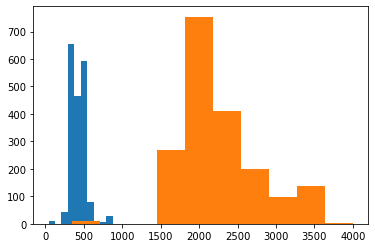

In [7]:
window_center = metadata.WindowCenter.values
window_width = metadata.WindowWidth.values

#blue is center and orange is width
plt.hist(window_center)
plt.hist(window_width)

In [8]:
#default values set to mode of window center and window width
default_window_center = metadata.WindowCenter.mode()
default_window_width = metadata.WindowWidth.mode()

In [9]:
#Adapted from:
#https://pydicom.github.io/pydicom/dev/auto_examples/image_processing/reslice.html
def create_3d(case):
    files = []
    fns = get_dicom_files(case)
    for fn in fns:
        files.append(pydicom.dcmread(fn))
        
    # skip files with no InstanceNumber (eg. Scout)
    slices = []
    skipcount = 0
    for f in files:
        if hasattr(f, 'InstanceNumber'):
            slices.append(f)
        else:
            skipcount = skipcount + 1

    if skipcount > 0:
        print("skipped, no InstanceNumber: {}".format(skipcount))

    # ensure they are in the correct order
    slices = sorted(slices, key=lambda s: s.ImagePositionPatient[2])
    dcm = slices[0]

    # pixel aspects, assuming all slices are the same
    ps = dcm.PixelSpacing
    ss = dcm.SliceThickness
    #ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    #cor_aspect = ss/ps[0]
    
    # create 3D array
    img_shape = list(dcm.pixel_array.shape)
    img_shape.append(len(slices))
    img3d = np.zeros(img_shape)
    
    # fill 3D array with the images from the files
    for i, s in enumerate(slices):
        img2d = dcm_apply_windows(s)
        img3d[:, :, i] = img2d
        
    return img3d, sag_aspect, fn.parent.name

def save_sag(img3d, sag_aspect, folder_name, interval=5):
    img_shape = img3d.shape
    #i=5
    for i in range(-4 * interval, 5 * interval, interval):
        arr = img3d[:, img_shape[1]//2 + i, :] * sag_aspect
        #flip and rotate so that C1 is at the top
        arr = np.fliplr(arr)
        arr = np.transpose(arr)
        #array is a tensor from 0 - 1.0, multiply by 256 to get 8 bit image
        arr *= 256
        dir_name = f"project_data/project_analysis/sag/{folder_name}"
        if not os.path.isdir(dir_name):
             os.makedirs(f"project_data/project_analysis/sag/{folder_name}", exist_ok=True)
        im = Image.fromarray(arr)
        #to avoid error from F mode
        if im.mode != 'RGB':
            im = im.convert('RGB')
        save_fn = f'project_data/project_analysis/sag/{folder_name}/{folder_name}_{i}.jpg'
        if save_fn not in dir_name:
            im.save(save_fn)

In [10]:
def get_window_from_dicom(dcm, default = (default_window_width,default_window_center)):
    """
    Returns window width and window center values or first example if MultiValue
    Strips comma from value if present (seen in a different dataset)
    If no window width/level is provided or available, returns default.
    """
    width, level = default

    if "WindowWidth" in dcm:
        width = dcm.WindowWidth
        if isinstance(width, pydicom.multival.MultiValue):
            width = float(width[0])
        else:
            width = float(str(width).replace(',', ''))

    if "WindowCenter" in dcm:
        level = dcm.WindowCenter
        if isinstance(level, pydicom.multival.MultiValue):
            level = float(level[0])
        else:
            level = float(str(level).replace(',', ''))
            
    return width, level


def dcm_apply_windows(dcm):
    """
    Applies Intercept/Slope and Window Center/Width
    """
    arr = dcm.pixel_array
    #slope, intercept
    slope = 1
    intercept = 0
    if "RescaleIntercept" in dcm and "RescaleSlope" in dcm:
        intercept = int(dcm.RescaleIntercept)
        slope = int(dcm.RescaleSlope)
        
    arr = arr * slope + intercept
    
    #window
    width,level = get_window_from_dicom(dcm)
    if width is not None and level is not None:
        arr = np.clip(arr, level - width // 2, level + width // 2)
        
     #scale
    arr = (arr - np.min(arr)) / np.max(arr)
        
    return arr

In [11]:
def show_case(folder_name, interval=5):
    plt.figure(figsize=(16, 12))
    count = 1
    #for i in range(-4 * interval, 5 * interval, interval):
    print(5)
    fn = f'project_data/project_analysis/sag/{folder_name}/{folder_name}_{5}.jpg'
    print("found image")
    img = mpimg.imread(fn)
    print("read image")
    plt.subplot(3,3,count)
    count += 1
    plt.imshow(img, cmap='bone')
    plt.axis("off")
    plt.show()

5
found image
read image


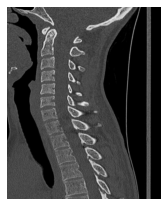

In [12]:
case = DATA_DIR/'train_images/1.2.826.0.1.3680043.2487'

img3d, sag_aspect, folder_name = create_3d(case)
save_sag( img3d, sag_aspect, folder_name)
show_case('1.2.826.0.1.3680043.2487')

In [ ]:
def to_sag(case):
    img3d, sag_aspect, folder_name = create_3d(case)
    save_sag( img3d, sag_aspect, folder_name)
    #print(str(case) + " complete")

    
cases = (DATA_DIR/"train_images").glob('*')
#parallel(to_sag, list(cases))
i = 0
for case in tqdm(list(cases)):
    print("Patient #" + str(i) + " complete")
    to_sag(case)
    i += 1
    


  0%|          | 0/1882 [00:00<?, ?it/s]

Patient #0 complete
Patient #1 complete
Patient #2 complete
Patient #3 complete
Patient #4 complete
Patient #5 complete
Patient #6 complete
Patient #7 complete
Patient #8 complete
Patient #9 complete
Patient #10 complete
Patient #11 complete
Patient #12 complete
Patient #13 complete
Patient #14 complete
Patient #15 complete
Patient #16 complete
Patient #17 complete
Patient #18 complete
Patient #19 complete
Patient #20 complete
Patient #21 complete
Patient #22 complete
Patient #23 complete
Patient #24 complete
Patient #25 complete
Patient #26 complete
Patient #27 complete


In [ ]:
cases = (DATA_DIR/"train_images").glob('*')
print(next(cases))

#instead of showing 9 cases, show one image

In [32]:
to_sag('1.2.826.0.1.3680043.12138')


show_case('1.2.826.0.1.3680043.12138')

NameError: name 'to_sag' is not defined

In [1]:
%ls

alternative-sagittal-view-11-22-2022.ipynb
alternative-sagittal-view.ipynb
project_data/
project_models/
rsna-2022-cervical-spine-fracture-detection.zip
test-file.ipynb
test.txt


In [2]:
%cd project_data/project_analysis/

/work/courses/cs7150-AL-SK/project_data/project_analysis


In [4]:
%ls
%cd sag

df.csv  sag/
/work/courses/cs7150-AL-SK/project_data/project_analysis/sag


In [5]:
%ls -1 | wc -l

1882
